# Imports and Define Paths

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import glob
import os
import time
import pickle

from colorama import Fore, Style
from tensorflow import keras
from google.cloud import storage


from pathlib import Path
from colorama import Fore, Style
from dateutil.parser import parse
from typing import Dict, List, Tuple, Sequence
from datetime import datetime

from power.params import *
from power.ml_ops.data import get_data_with_cache, load_data_to_bq, clean_pv_data
from power.ml_ops.model import initialize_model, compile_model, train_model
from power.ml_ops.registry import load_model, save_model, save_results
from power.ml_ops.cross_val import get_Xi_yi, get_X_y_seq

# Load Processed data and split into train and test sets

In [ ]:
print(Fore.MAGENTA + "\n⭐️ Use case: train" + Style.RESET_ALL)
print(Fore.BLUE + "\nLoading preprocessed validation data..." + Style.RESET_ALL)


# Load processed data using `get_data_with_cache` in chronological order

query = f"""
    SELECT *
    FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
    ORDER BY utc_time
"""

data_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
data_processed = get_data_with_cache(
    gcp_project=GCP_PROJECT,
    query=query,
    cache_path=data_processed_cache_path,
    data_has_header=True
)

# the model uses power as feature -> fix that in raw data
data_processed = data_processed.rename(columns={'electricity': 'power'})
# the processed data form bq needs to be converted to datetime object
data_processed.utc_time = pd.to_datetime(data_processed.utc_time,utc=True)

if data_processed.shape[0] < 240:
    print("❌ Not enough processed data retrieved to train on")
    # return None


# Split the data into training and testing sets
train = data_processed[data_processed['utc_time'] < '2020-01-01']
test = data_processed[data_processed['utc_time'] >= '2020-01-01']

train = train[['power']]
test = test[['power']]


In [ ]:
X_train, y_train = get_X_y_seq(train,
                                number_of_sequences=10_000,
                                input_length=48,
                                output_length=24)

# Define Model

In [ ]:
import pandas as pd

from tensorflow.keras import models, layers, optimizers, metrics
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping

def initialize_model(X_train, y_train, n_unit=24):

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(n_unit,
                          activation='tanh',
                          return_sequences = False,
                          input_shape=(X_train.shape[1],X_train.shape[2])
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    return model

def compile_model(model, learning_rate=0.02):

    # def r_squared(y_true, y_pred):
    #     ss_res = K.sum(K.square(y_true - y_pred))
    #     ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    #     return (1 - ss_res/(ss_tot + K.epsilon()))

    adam = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=adam, metrics=['mae']) #, r_squared])

    return model

def train_model(model,
                X_train,
                y_train,
                validation_split = 0.3,
                batch_size = 32,
                epochs = 50):
    es = EarlyStopping(monitor = "val_mae",
                       mode = "min",
                       patience = 5,
                       restore_best_weights = True)
    history = model.fit(X_train, y_train,
                        validation_split=validation_split,
                        shuffle=False,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks = [es],
                        verbose = 0)
    return model, history

# Train model

In [ ]:
model = initialize_model(X_train, y_train, n_unit=24)

In [ ]:
model.summary()

In [ ]:
model = compile_model(model, learning_rate=0.02)

In [ ]:
model, history = train_model(model,
                                X_train,
                                y_train,
                                validation_split = 0.3,
                                batch_size = 32,
                                epochs = 50
                                )

In [ ]:
val_mae = np.min(history.history['val_mae'])
val_mae


In [ ]:
params = dict(
    context="train",
    training_set_size='40 years worth of data',
    row_count=len(X_train),
)
params

# Attempt to save & load model

## 1. Save

In [ ]:
def save_model(model: keras.Model = None) -> None:
    """
    Persist trained model locally on the hard drive at f"{LOCAL_REGISTRY_PATH}/models/{timestamp}.h5"
    - if MODEL_TARGET='gcs', also persist it in your bucket on GCS at "models/{timestamp}.h5" --> unit 02 only
    - if MODEL_TARGET='mlflow', also persist it on MLflow instead of GCS (for unit 0703 only) --> unit 03 only
    """

    timestamp = time.strftime("%Y%m%d-%H%M%S")

    # Save model locally
    model_path = os.path.join(LOCAL_REGISTRY_PATH, "models", f"{timestamp}.h5")
    model.save(model_path)

    print("✅ Model saved locally")

    if MODEL_TARGET == "gcs":
        # 🎁 We give you this piece of code as a gift. Please read it carefully! Add a breakpoint if needed!
        print(Fore.BLUE + f"\nSave model to GCS @ {BUCKET_NAME}..." + Style.RESET_ALL)

        model_filename = model_path.split("/")[-1] # e.g. "20230208-161047.h5" for instance
        client = storage.Client()
        bucket = client.bucket(BUCKET_NAME)
        blob = bucket.blob(f"models/{model_filename}")
        blob.upload_from_filename(model_path)

        print("✅ Model saved to GCS")

        return None


    return None

## 2. Load

In [ ]:
MODEL_TARGET

In [ ]:
def load_model(stage="Production") -> keras.Model:
    """
    Return a saved model:
    - locally (latest one in alphabetical order)
    - or from GCS (most recent one) if MODEL_TARGET=='gcs'  --> for unit 02 only
    - or from MLFLOW (by "stage") if MODEL_TARGET=='mlflow' --> for unit 03 only

    Return None (but do not Raise) if no model is found

    """

    if MODEL_TARGET == "local":
        print(Fore.BLUE + f"\nLoad latest model from local registry..." + Style.RESET_ALL)

        # Get the latest model version name by the timestamp on disk
        local_model_directory = os.path.join(LOCAL_REGISTRY_PATH, "models")
        local_model_paths = glob.glob(f"{local_model_directory}/*")

        if not local_model_paths:
            return None

        most_recent_model_path_on_disk = sorted(local_model_paths)[-1]

        print(Fore.BLUE + f"\nLoad latest model from disk..." + Style.RESET_ALL)

        latest_model = keras.models.load_model(most_recent_model_path_on_disk)

        print("✅ Model loaded from local disk")

        return latest_model

    elif MODEL_TARGET == "gcs":
        # 🎁 We give you this piece of code as a gift. Please read it carefully! Add a breakpoint if needed!
        print(Fore.BLUE + f"\nLoad latest model from GCS..." + Style.RESET_ALL)

        client = storage.Client()
        blobs = list(client.get_bucket(BUCKET_NAME).list_blobs(prefix="model"))

        try:
            latest_blob = max(blobs, key=lambda x: x.updated)
            latest_model_path_to_save = os.path.join(LOCAL_REGISTRY_PATH, latest_blob.name)
            latest_blob.download_to_filename(latest_model_path_to_save)

            latest_model = keras.models.load_model(latest_model_path_to_save)

            print("✅ Latest model downloaded from cloud storage")

            return latest_model
        except:
            print(f"\n❌ No model found in GCS bucket {BUCKET_NAME}")

            return None

    else:
        return None

In [ ]:
latest_model = load_model()

In [ ]:
latest_model.summary()

# Test Pred function

In [54]:
def pred(input_pred:str = '2013-05-08 12:00:00',
         min_date = '2020-01-01 00:00:00',
         max_date = '2022-12-29 23:00:00') -> pd.DataFrame:
    """
    Make a prediction using the latest trained model
    """

    print("\n⭐️ Use case: predict")

    query = f"""
        SELECT *
        FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
        ORDER BY utc_time
    """

    data_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
    data_processed = get_data_with_cache(
        gcp_project=GCP_PROJECT,
        query=query,
        cache_path=data_processed_cache_path,
        data_has_header=True
    )

    # X_pred should be the 48 hours before the input date
    X_pred = data_processed[data_processed['utc_time'] < input_pred][-48:]

    # we have to rename columns because model is using 'power' as coulumns name
    # X_pred= X_pred.rename(columns={'electricity': 'power'})

    # convert X_pred to a tensorflow object
    X_pred = X_pred[['electricity']].to_numpy()
    X_pred_tf = tf.convert_to_tensor(X_pred)
    X_pred_tf = tf.expand_dims(X_pred_tf, axis=0)

    model = load_model()
    assert model is not None

    y_pred = model.predict(X_pred_tf)

    # y_pred dates shoud be the 24hours after a 12 hour gap
    y_pred_df = data_processed[data_processed['utc_time'] > input_pred][12:36]
    y_pred_df['electricity'] = y_pred[0]

    print("\n✅ prediction done: ", y_pred, y_pred.shape, "\n")

    return y_pred_df

y_pred = pred(input_pred = '2013-05-08 12:00:00',
         min_date = '2020-01-01 00:00:00',
         max_date = '2022-12-29 23:00:00')
y_pred


⭐️ Use case: predict

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)

Load latest model from GCS...


2024-03-11 12:41:16.329634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-11 12:41:16.338405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-11 12:41:16.343817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Latest model downloaded from cloud storage


2024-03-11 12:41:17.778268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-11 12:41:17.784236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-11 12:41:17.787062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step

✅ prediction done:  [[ 0.50191534  0.43679875  0.31974342  0.21163341  0.12414482  0.04900397
  -0.00690743 -0.01890136 -0.02430899 -0.01081144  0.00795818  0.02925391
   0.01867648  0.00206484 -0.0047964   0.00402194  0.0349185   0.08704953
   0.17900188  0.30466172  0.39315158  0.47727764  0.534937    0.54961723]] (1, 24) 



,utc_time,local_time,electricity
292368,2013-05-09 00:00:00+00:00,2013-05-09 00:00:00+00:00,0.501915
292369,2013-05-09 01:00:00+00:00,2013-05-09 01:00:00+00:00,0.436799
292370,2013-05-09 02:00:00+00:00,2013-05-09 02:00:00+00:00,0.319743
292371,2013-05-09 03:00:00+00:00,2013-05-09 03:00:00+00:00,0.211633
292372,2013-05-09 04:00:00+00:00,2013-05-09 04:00:00+00:00,0.124145
292373,2013-05-09 05:00:00+00:00,2013-05-09 05:00:00+00:00,0.049004
292374,2013-05-09 06:00:00+00:00,2013-05-09 06:00:00+00:00,-0.006907
292375,2013-05-09 07:00:00+00:00,2013-05-09 07:00:00+00:00,-0.018901
292376,2013-05-09 08:00:00+00:00,2013-05-09 08:00:00+00:00,-0.024309
292377,2013-05-09 09:00:00+00:00,2013-05-09 09:00:00+00:00,-0.010811


<Axes: >

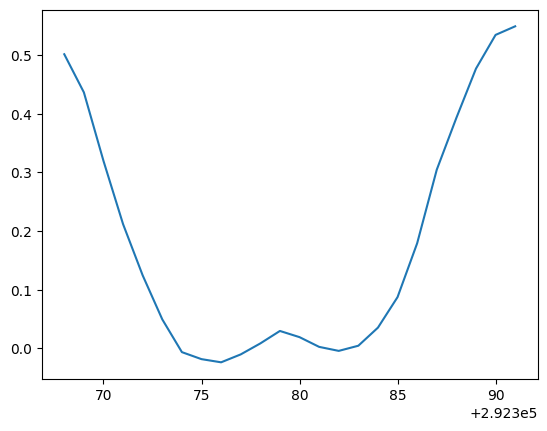

In [55]:
y_pred.electricity.plot()

In [25]:
query = f"""
        SELECT *
    FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
    ORDER BY utc_time
"""

data_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
data_processed = get_data_with_cache(
    gcp_project=GCP_PROJECT,
    query=query,
    cache_path=data_processed_cache_path,
    data_has_header=True
)



Load data from local CSV...
✅ Data loaded, with shape (376944, 3)


In [42]:
y_pred_dates = data_processed[data_processed['utc_time'] > input_pred]['utc_time'][12:36]
type(y_pred_dates), type(pd.Series(y_pred[0]))

(pandas.core.series.Series, pandas.core.series.Series)

In [50]:
y_pred[0]

array([ 0.50191534,  0.43679875,  0.31974342,  0.21163341,  0.12414482,
        0.04900397, -0.00690743, -0.01890136, -0.02430899, -0.01081144,
        0.00795818,  0.02925391,  0.01867648,  0.00206484, -0.0047964 ,
        0.00402194,  0.0349185 ,  0.08704953,  0.17900188,  0.30466172,
        0.39315158,  0.47727764,  0.534937  ,  0.54961723], dtype=float32)

In [52]:
y_pred_df = data_processed[data_processed['utc_time'] > input_pred][12:36]
y_pred_df['electricity'] = y_pred[0]
y_pred_df

,utc_time,local_time,electricity
292368,2013-05-09 00:00:00+00:00,2013-05-09 00:00:00+00:00,0.501915
292369,2013-05-09 01:00:00+00:00,2013-05-09 01:00:00+00:00,0.436799
292370,2013-05-09 02:00:00+00:00,2013-05-09 02:00:00+00:00,0.319743
292371,2013-05-09 03:00:00+00:00,2013-05-09 03:00:00+00:00,0.211633
292372,2013-05-09 04:00:00+00:00,2013-05-09 04:00:00+00:00,0.124145
292373,2013-05-09 05:00:00+00:00,2013-05-09 05:00:00+00:00,0.049004
292374,2013-05-09 06:00:00+00:00,2013-05-09 06:00:00+00:00,-0.006907
292375,2013-05-09 07:00:00+00:00,2013-05-09 07:00:00+00:00,-0.018901
292376,2013-05-09 08:00:00+00:00,2013-05-09 08:00:00+00:00,-0.024309
292377,2013-05-09 09:00:00+00:00,2013-05-09 09:00:00+00:00,-0.010811
